In [9]:
from __future__ import annotations

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from edpyt.dmft import DMFT, SpinGfimp
from edpyt.nano_dmft import Gfimp as nanoGfimp
from edpyt.nano_dmft import Gfloc
from scipy.interpolate import interp1d

In [ ]:
def distance(delta):
    global delta_prev
    delta_prev[:] = delta
    return dmft.distance(delta)


def save_sigma(sigma_diag, output_folder, nspin):
    L, nspin, ne = sigma_diag.shape
    sigma = np.zeros((ne, L, L), complex)

    def save(spin):
        suffix = ["up", "dw"][spin]
        for diag, mat in zip(sigma_diag[:, spin, :].T, sigma):
            mat.flat[:: (L + 1)] = diag
        np.save(f"{output_folder}/sigma_dmft_{suffix}.npy", sigma)

    for spin in range(nspin):
        save(spin)


def plot(gf, ax=None, eta=1e-5, semilogy=True):
    """Plot the Green's function."""
    if ax is None:
        fig, ax = plt.subplots()
    if semilogy:
        show = getattr(ax, 'semilogy')
    else:
        show = getattr(ax, 'plot')
    w = z_ret.real
    dos = -1/np.pi * gf(z_ret.real+1.j*eta).sum(0).imag
    if dos.ndim>1:
        show(w, dos[0], label=r'spin $\uparrow$')
        show(w, dos[1], label=r'spin $\downarrow$')
    else:
        show(w, dos, label=r'spin $\uparrow$ & $\downarrow$')
    ax.set_xlim(w.min(), w.max())
    ax.set_xlabel('E-E$_F$ [eV]')
    ax.set_ylabel('DOS [a.u.]')
    ax.legend()
    return ax #use ax.get_figure() to get fig


In [49]:
def plot_dos_and_sigma(gf, sigma_func, semilogy=False, reference_gf=None, label_ref="DFT"):
    """Plot the spin-resolved Green's function DOS and Tr(Sigma)."""

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Plot DOS
    w = z_ret.real
    dos = -1 / np.pi * gf(z_ret).sum(axis=(0)).imag
    if semilogy:
        ax1.semilogy(w, dos[0], label=r"spin $\uparrow$")
        ax1.semilogy(w, dos[1], label=r"spin $\downarrow$")
    else:
        ax1.plot(w, dos[0], label=r"spin $\uparrow$")
        ax1.plot(w, dos[1], label=r"spin $\downarrow$")

    ax1.set_ylabel("DOS [a.u.]")
    ax1.legend(loc="upper right")

    # Plot Self-Energy
    sigma = sigma_func(z_ret)
    trace_sigma = sigma.sum(axis=(0))

    ax2.plot(w, trace_sigma[0].real, label=r"Re Tr($\Sigma$) spin $\uparrow$", color="blue")
    ax2.plot(w, trace_sigma[0].imag, label=r"Im Tr($\Sigma$) spin $\uparrow$", color="orange")
    ax2.plot(w, trace_sigma[1].real, label=r"Re Tr($\Sigma$) spin $\downarrow$", color="green")
    ax2.plot(w, trace_sigma[1].imag, label=r"Im Tr($\Sigma$) spin $\downarrow$", color="red")

    ax2.set_xlabel(r"E - E$_F$ [eV]")
    ax2.set_ylabel("Tr($\Sigma$) [eV]")
    ax2.legend(loc="upper right")

    return fig

def plot_spin_occupation(gf, field=None):
    """Plot the spin occupation."""

    spin_occps = gf.get_occps(mu=gf.mu)
    impurities = np.arange(spin_occps.shape[0])
    spin_up = spin_occps[:, 0]
    spin_down = spin_occps[:, 1]

    total_spin = np.sum((spin_occps[:, 0] - spin_occps[:, 1]) / 2)
    staggered_spin = np.sum((-1) ** impurities * (spin_occps[:, 0] - spin_occps[:, 1]) / 2)

    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot spin up and spin down as stacked bars
    ax.bar(impurities, spin_up, label='Spin ↑', color='steelblue', width=0.8)
    ax.bar(impurities, spin_down, bottom=spin_up, label='Spin ↓', color='lightcoral', width=0.8)

    for i in range(len(impurities)):
        total = spin_up[i] + spin_down[i]
        ax.text(i, total + 0.05, f'{total:.2f}', ha='center', fontsize=9)
        if total != 0:
            # Compute percentage contributions within each impurity
            up_percent = (spin_up[i] / total) * 100
            down_percent = (spin_down[i] / total) * 100

            # Write percentage inside the bar for spin ↑
            ax.text(i, spin_up[i] / 2, f'{up_percent:.1f}%',
                    ha='center', va='center', color='white', fontsize=9)

            # Write percentage inside the bar for spin ↓
            ax.text(i, spin_up[i] + spin_down[i] / 2, f'{down_percent:.1f}%',
                    ha='center', va='center', color='black', fontsize=9)

    # Display total and staggered spin in the plot area (centered)
    text_x = len(impurities) / 2
    text_y = max(spin_up + spin_down) * 0.8
    ax.text(text_x, text_y, f'Total Spin: {total_spin:.4f}',
            ha='center', va='center', fontsize=12, color='black')
    ax.text(text_x, text_y * 0.92, f'Staggered Spin: {staggered_spin:.4f}',
            ha='center', va='center', fontsize=12, color='black')

    ax.set_xlabel('Impurity Index')
    ax.set_ylabel('Occupation')

    if field is not None:
        ax.set_title(f"Spin Occupation for Field = {field} eV")

    ax.set_xlim(-0.5, len(impurities) - 0.5)
    ax.set_xticks(impurities)
    ax.legend()

    return fig


iteration_counter = 0


def callback(*args, **kwargs):
    global iteration_counter

    # First figure: DOS and Self-Energy
    fig1 = plot_dos_and_sigma(
        gf=gfloc,
        sigma_func=_Sigma,
        reference_gf=gfloc0,
        label_ref="DFT",
        semilogy=kwargs.get("semilogy", False),
    )

    mu_value = gfloc.mu
    fig1.suptitle(f"Callback Iteration {iteration_counter} | $\mu$ = {mu_value:.4f} eV")

    figure_filename = os.path.join(
        figure_folder,
        f"callback_iter_{iteration_counter:03d}_mu_{mu_value:.4f}_dos_sigma.png",
    )
    plt.savefig(figure_filename, dpi=300, bbox_inches="tight")
    plt.close()

    # Second figure: Spin Occupation
    fig2 = plot_spin_occupation(
        gf=gfloc,
        field=field
    )

    figure_filename = os.path.join(
        figure_folder, f"callback_iter_{iteration_counter:03d}_spin_occupation.png"
    )
    plt.savefig(figure_filename, dpi=300, bbox_inches="tight")
    plt.close()

    iteration_counter += 1


In [50]:
nbaths = 4
nspin = 2
# U = 4
tol = 1e-4
max_iter = 1000
alpha = 0.0
de = 0.01
energies = np.arange(-3, 3 + de / 2.0, de).round(7)
eta = 1e-3
z_ret = energies + 1.0j * eta
beta = 70.0
mu = 0.0
adjust_mu = True
use_double_counting = True

data_folder = "output/lowdin"
output_folder = f"{data_folder}/dmft/spin"
figure_folder = f"{output_folder}/figures"

occupancy_goal = np.load(f"{data_folder}/occupancies.npy")
H_active = np.load(f"{data_folder}/bare_hamiltonian.npy").real
z_mats = np.load(f"{data_folder}/matsubara_energies.npy")

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
    hs_list_ii = pickle.load(f)

with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
    hs_list_ij = pickle.load(f)

os.makedirs(output_folder, exist_ok=True)
os.makedirs(figure_folder, exist_ok=True)

In [51]:
len_active = occupancy_goal.size
hyb_mats = np.fromfile(f"{data_folder}/matsubara_hybridization.bin", complex).reshape(
    z_mats.size,
    len_active,
    len_active,
)
_HybMats = interp1d(z_mats.imag, hyb_mats, axis=0, bounds_error=False, fill_value=0.0)
HybMats = lambda z: _HybMats(z.imag)

S_active = np.eye(len_active)
idx_neq = np.arange(len_active)
idx_inv = np.arange(len_active)

# V = np.eye(len_active) * U
V = np.loadtxt(f"{data_folder}/U_matrix.txt")

# Apply double counting correction if specified
double_counting = (
    np.diag(V.diagonal() * (occupancy_goal - 0.5))
    if use_double_counting
    else np.zeros((len_active, len_active))
)

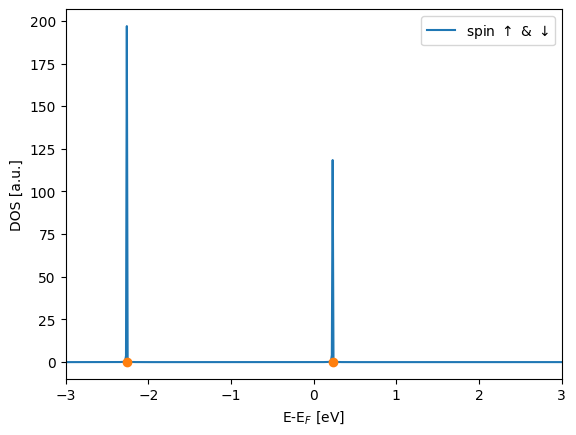

In [52]:
gfloc0= Gfloc(
    H_active,
    S_active,
    HybMats,
    idx_neq,
    idx_inv,
    nmats=z_mats.size,
    beta=beta,
)
nimp = gfloc0.idx_neq.size
Sigma = lambda z: np.zeros((nimp, z.size), complex)
gfloc0.update(mu=mu)
gfloc0.set_local(Sigma)
eigvals = np.load(f"{data_folder}/eigvals_Hbare.npy")
ax = plot(gfloc0, eta=eta, semilogy=False)
ax.plot(eigvals, np.zeros_like(eigvals), 'o')

<Axes: xlabel='E-E$_F$ [eV]', ylabel='DOS [a.u.]'>

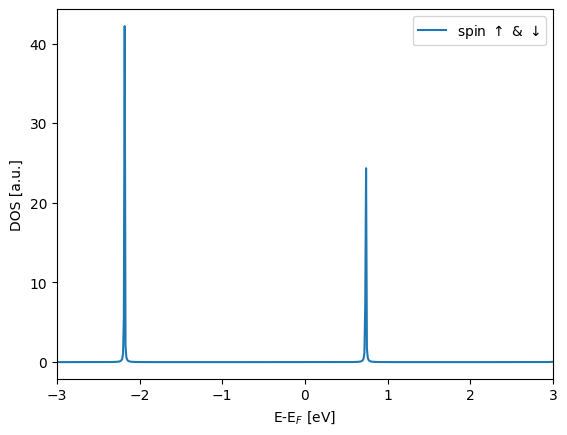

In [53]:
gfloc = Gfloc(
    H_active - double_counting,
    S_active,
    HybMats,
    idx_neq,
    idx_inv,
    nmats=z_mats.size,
    beta=beta,
)
Sigma = lambda z: np.zeros((nimp, z.size), complex)
gfloc.update(mu=mu)
gfloc.set_local(Sigma)
plot(gfloc, eta=eta, semilogy=False)

In [54]:
gfimp = [SpinGfimp(nbaths, z_mats.size, V[i, i], beta) for i in range(nimp)]
gfimp = nanoGfimp(gfimp)

In [55]:
def _Sigma(z):
    return (
        -double_counting.diagonal()[:, None, None]
        - gfloc.mu
        + gfloc.Sigma(z)[idx_inv, :]
    )


# Initialize DMFT with adjust_mu parameter
dmft = DMFT(
    gfimp,
    gfloc,
    occupancy_goal,
    max_iter=max_iter,
    tol=tol,
    adjust_mu=adjust_mu,
    alpha=alpha,
    DC=double_counting,
)


In [56]:
fields = [5] #[0.00, 5e-3, 5e-2, 5e-1,5]
signs = np.zeros(nimp, int)
signs[::2] = -1
signs[1::2] = 1

for field in fields:
    delta = dmft.initialize_magnetic(V.diagonal().mean(), Sigma, signs, field, mu=mu)

Total Spin: 0.2176
Staggered Spin: -0.3080


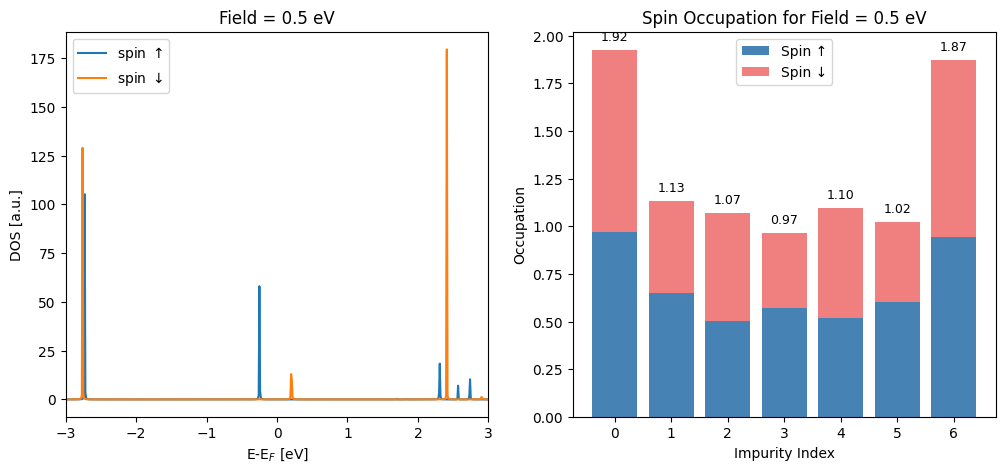

In [57]:
fields = [0.5] #[0.00, 5e-3, 5e-2, 5e-1,5]
signs = np.zeros(nimp, int)
signs[::2] = -1
signs[1::2] = 1

for field in fields:
    delta = dmft.initialize_magnetic(V.diagonal().mean(), Sigma, signs, field, mu=mu)
    delta_prev = delta.copy()
    dmft.delta = delta

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax = plot(gfloc, eta=eta, semilogy=False, ax=ax1)
    ax.set_title(f"Field = {field} eV")

    spin_occps = gfloc.get_occps(mu=gfloc.mu)
    impurities = np.arange(spin_occps.shape[0])
    spin_up = spin_occps[:, 0]
    spin_down = spin_occps[:, 1]

    total_spin = np.sum((spin_occps[:, 0] - spin_occps[:, 1]) / 2)
    staggered_spin = np.sum((-1) ** np.arange(spin_occps.shape[0]) * (spin_occps[:, 0] - spin_occps[:, 1]) / 2)
    print(f"Total Spin: {total_spin:.4f}")
    print(f"Staggered Spin: {staggered_spin:.4f}")

    ax2.bar(impurities, spin_up, label='Spin ↑', color='steelblue')

    ax2.bar(impurities, spin_down, bottom=spin_up, label='Spin ↓', color='lightcoral')

    for i in range(len(impurities)):
        total = spin_up[i] + spin_down[i]
        ax2.text(i, total + 0.05, f'{total:.2f}', ha='center', fontsize=9)

    ax2.set_xlabel('Impurity Index')
    ax2.set_ylabel('Occupation')
    ax2.set_title(f'Spin Occupation for Field = {field} eV')
    ax2.set_xticks(impurities)
    ax2.legend()

    plt.show()


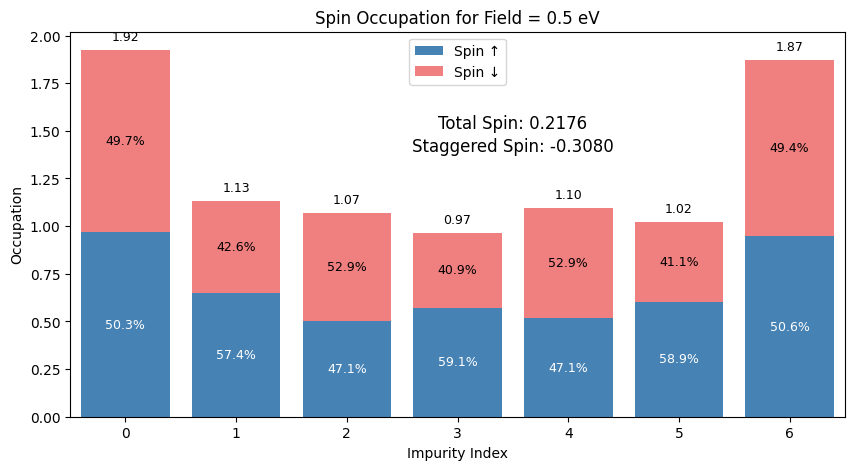

In [58]:
for field in fields:

    spin_occps = gfloc.get_occps(mu=gfloc.mu)
    impurities = np.arange(spin_occps.shape[0])
    spin_up = spin_occps[:, 0]
    spin_down = spin_occps[:, 1]

    total_spin = np.sum((spin_occps[:, 0] - spin_occps[:, 1]) / 2)
    staggered_spin = np.sum((-1) ** impurities * (spin_occps[:, 0] - spin_occps[:, 1]) / 2)

    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot spin up and spin down as stacked bars
    ax.bar(impurities, spin_up, label='Spin ↑', color='steelblue', width=0.8)
    ax.bar(impurities, spin_down, bottom=spin_up, label='Spin ↓', color='lightcoral', width=0.8)

    for i in range(len(impurities)):
        total = spin_up[i] + spin_down[i]
        ax.text(i, total + 0.05, f'{total:.2f}', ha='center', fontsize=9)
        if total != 0:
            # Compute percentage contributions within each impurity
            up_percent = (spin_up[i] / total) * 100
            down_percent = (spin_down[i] / total) * 100

            # Write percentage inside the bar for spin ↑
            ax.text(i, spin_up[i] / 2, f'{up_percent:.1f}%',
                    ha='center', va='center', color='white', fontsize=9)

            # Write percentage inside the bar for spin ↓
            ax.text(i, spin_up[i] + spin_down[i] / 2, f'{down_percent:.1f}%',
                    ha='center', va='center', color='black', fontsize=9)

    # Display total and staggered spin in the plot area (centered)
    text_x = len(impurities) / 2
    text_y = max(spin_up + spin_down) * 0.8
    ax.text(text_x, text_y, f'Total Spin: {total_spin:.4f}',
            ha='center', va='center', fontsize=12, color='black')
    ax.text(text_x, text_y * 0.92, f'Staggered Spin: {staggered_spin:.4f}',
            ha='center', va='center', fontsize=12, color='black')

    ax.set_xlabel('Impurity Index')
    ax.set_ylabel('Occupation')

    if field is not None:
        ax.set_title(f"Spin Occupation for Field = {field} eV")

    ax.set_xlim(-0.5, len(impurities) - 0.5)
    ax.set_xticks(impurities)
    ax.legend()


In [59]:
# try:
#     dmft.solve(dmft.delta, alpha=1.0, callback=callback)
# except:
#     pass
dmft.solve(dmft.delta, alpha=1.0, callback=callback)


Iteration :  0
Occupation : 8.54025 Chemical potential : -0.34119 Error : 57.19705664 Relative Error : 0.51827509
Iteration :  1
Occupation : 8.54025 Chemical potential : -0.40472 Error : 17.81229257 Relative Error : 0.17485663
0:  |F(x)| = 8.35659; step 1
Iteration :  2


KeyboardInterrupt: 

In [25]:
save_sigma(_Sigma(z_ret), output_folder, nspin)

gfloc_data = gfloc(z_ret)
np.save(f"{output_folder}/dmft_gfloc.npy", gfloc_data)

np.save(f"{output_folder}/opt_delta_dmft", delta_prev)
np.save(f"{output_folder}/opt_mu_dmft", gfloc.mu)

print("Spin resolved DMFT calculation finished.", flush=True)

Spin resolved DMFT calculation finished.


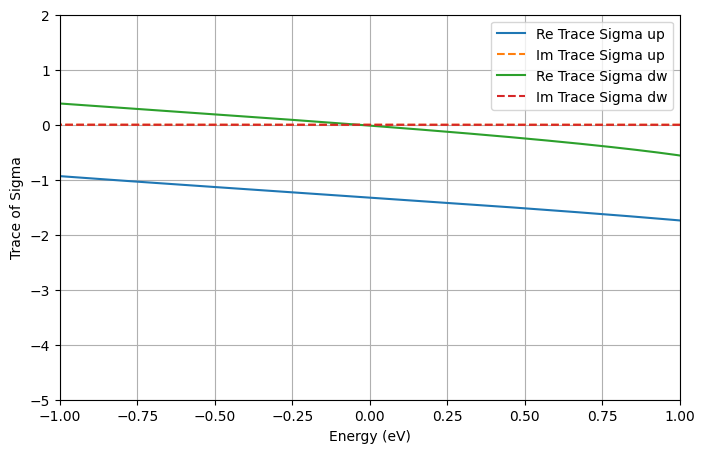

In [8]:
import numpy as np
import matplotlib.pyplot as plt

traces = []
nspin = 2

data_folder = "output/lowdin"
output_folder = f"{data_folder}/dmft/spin"
de = 0.01
energies = np.arange(-3, 3 + de / 2.0, de).round(7)
for spin in range(nspin):
    suffix = ["up", "dw"][spin]
    sigma = np.load(f"{output_folder}/sigma_dmft_{suffix}.npy")
    trace = np.trace(sigma, axis1=1, axis2=2)
    traces.append(trace)

# Plotting
plt.figure(figsize=(8, 5))
for spin in range(nspin):
    suffix = ["up", "dw"][spin]
    plt.plot(energies, traces[spin].real, label=f"Re Trace Sigma {suffix}")
    plt.plot(energies, traces[spin].imag, '--', label=f"Im Trace Sigma {suffix}")

plt.xlabel("Energy (eV)")
plt.ylabel("Trace of Sigma")
plt.legend()
plt.grid()
plt.xlim(-1,1)
plt.ylim(-5,2)
plt.show()
